In [16]:
# Import dependencies
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
# Create an instance of MongoClient
mongo = MongoClient(port=27017)

# assign the met database to a variable name
db = mongo['met']

# assign the collection to a variable
artifacts = db['artifacts']

In [18]:
# Build the aggregation pipeline

# Write an aggregation query that counts the number of documents, grouped by "Country", then "classification"
group_query = {'$group': {'_id': {"country": "$country",
                                  "classification": "$classification"}, 
                          'count': { '$sum': 1 }
                         }
              }

# Create a match query that matches only the rows that have 5 or more documents in 'count'
match_query = {'$match': {'count': {'$gte': 5}}}

# Create a dictionary that will allow the pipeline to sort by country in alphabetical order, 
# then count in descending order
sort_values = {'$sort': { '_id.country': 1, 'count': -1 }}

# Put the pipeline together
pipeline = [group_query, match_query, sort_values]

In [19]:
# Run the pipeline through the aggregate method, cast the results as a list, and save the results to a variable
results = list(artifacts.aggregate(pipeline))

In [20]:
# Print the number of rows in the result
print("Number of rows in result: ", len(results))

Number of rows in result:  46


In [21]:
# Print the first 10 results
pprint(results[0:10])

[{'_id': {'classification': 'Bark-Paintings', 'country': 'Australia'},
  'count': 6},
 {'_id': {'classification': 'Wood-Sculpture', 'country': 'Burkina Faso'},
  'count': 18},
 {'_id': {'classification': 'Wood-Sculpture', 'country': 'Cameroon'},
  'count': 10},
 {'_id': {'classification': 'Bone/Ivory-Sculpture', 'country': 'Canada'},
  'count': 16},
 {'_id': {'classification': 'Stone-Sculpture', 'country': 'Canada'},
  'count': 11},
 {'_id': {'classification': 'Metal-Ornaments', 'country': 'Colombia'},
  'count': 22},
 {'_id': {'classification': 'Metal-Ornaments', 'country': 'Costa Rica'},
  'count': 7},
 {'_id': {'classification': 'Stone-Ornaments', 'country': 'Costa Rica'},
  'count': 5},
 {'_id': {'classification': 'Metal-Ornaments',
          'country': 'Costa Rica or Panama'},
  'count': 10},
 {'_id': {'classification': 'Wood-Sculpture', 'country': "Côte d'Ivoire"},
  'count': 34}]


In [22]:
# Extract the fields from the _id so they're in separate columns in a Pandas DataFrame
aggregated_df = pd.json_normalize(results)
aggregated_df.head()

,count,_id.country,_id.classification
0,6,Australia,Bark-Paintings
1,18,Burkina Faso,Wood-Sculpture
2,10,Cameroon,Wood-Sculpture
3,16,Canada,Bone/Ivory-Sculpture
4,11,Canada,Stone-Sculpture


In [23]:
# Rename the columns
aggregated_df = aggregated_df.rename(columns={"count": "number of artifacts",
                                              "_id.classification": "classification",
                                              "_id.country": "country"})
aggregated_df.head()

,number of artifacts,country,classification
0,6,Australia,Bark-Paintings
1,18,Burkina Faso,Wood-Sculpture
2,10,Cameroon,Wood-Sculpture
3,16,Canada,Bone/Ivory-Sculpture
4,11,Canada,Stone-Sculpture


In [24]:
# Reorder the columns
aggregated_df = aggregated_df[["country", "classification", "number of artifacts"]]

# Print the first 10 rows of the DataFrame
aggregated_df.head(10)

,country,classification,number of artifacts
0,Australia,Bark-Paintings,6
1,Burkina Faso,Wood-Sculpture,18
2,Cameroon,Wood-Sculpture,10
3,Canada,Bone/Ivory-Sculpture,16
4,Canada,Stone-Sculpture,11
5,Colombia,Metal-Ornaments,22
6,Costa Rica,Metal-Ornaments,7
7,Costa Rica,Stone-Ornaments,5
8,Costa Rica or Panama,Metal-Ornaments,10
9,Côte d'Ivoire,Wood-Sculpture,34


In [25]:
# Print out the unique countries
aggregated_df["country"].unique()

array(['Australia', 'Burkina Faso', 'Cameroon', 'Canada', 'Colombia',
       'Costa Rica', 'Costa Rica or Panama', "Côte d'Ivoire",
       'Democratic Republic of the Congo',
       'Ecuador, Peru, Bolivia, Chile, or Argentina', 'Indonesia',
       'Liberia', 'Mali', 'Mexico', 'Nigeria', 'Panama',
       'Papua New Guinea', 'Peru', 'United States', 'Western Australia'],
      dtype=object)

In [26]:
# Print out the unique classifications
aggregated_df["classification"].unique()

array(['Bark-Paintings', 'Wood-Sculpture', 'Bone/Ivory-Sculpture',
       'Stone-Sculpture', 'Metal-Ornaments', 'Stone-Ornaments',
       'Wood-Implements', 'Bone/Ivory-Ornaments', 'Sculpture-Sheet metal',
       'Textiles', 'Textiles-Woven', 'Bone/Ivory-Implements',
       'Ceramics-Containers', 'Wood-Architectural', 'Ceramics-Sculpture',
       'Ceramics-Implements', 'Bone/Ivory-Musical Instruments',
       'Bone/Ivory-Containers', 'Metal-Sculpture', 'Metal-Implements',
       'Shell-Ornaments', 'Shell'], dtype=object)

In [27]:
# Find out which countries have the most classifications
# Create a DataFrame that groups by country
countries_grouped = pd.DataFrame(aggregated_df[["country", "classification"]].groupby("country").count())

# Print the DataFrame, sorted in descending order on classification
countries_grouped.sort_values("classification", ascending=False)

,classification
country,
Indonesia,6
Nigeria,6
United States,5
Peru,4
Mexico,4
Democratic Republic of the Congo,3
Canada,2
Costa Rica,2
Papua New Guinea,2


In [28]:
# Create a DataFrame of just the Indonesian artifacts
ind_df = aggregated_df.loc[aggregated_df["country"]=="Indonesia",["classification", "number of artifacts"]]
ind_df

,classification,number of artifacts
15,Wood-Sculpture,14
16,Textiles,13
17,Textiles-Woven,12
18,Bone/Ivory-Implements,7
19,Ceramics-Containers,6
20,Wood-Architectural,5


<function matplotlib.pyplot.show(close=None, block=None)>

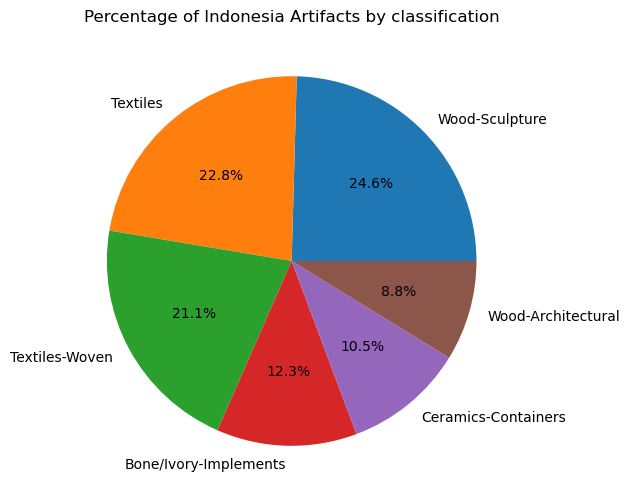

In [34]:
# Create a pie chart of the Indonesian artifacts
ind_df.plot(kind="pie",
            y="number of artifacts",
            autopct='%1.1f%%',
            ylabel='',
            labels=ind_df.classification,
            legend=False,
            title="Percentage of Indonesia Artifacts by classification",
            figsize=(6,6))
plt.savefig("/users/jt/Data Analytics/12.3/Activities/08-Grp_MiniProject_Part3/IndonesiaChart.png")
plt.show

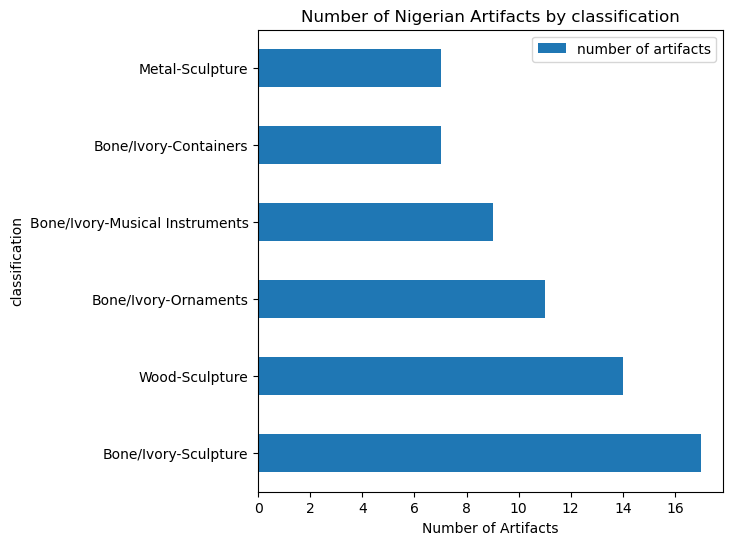

In [35]:
# Create a horizontal bar chart of the Nigerian artifacts
aggregated_df.loc[aggregated_df["country"]=="Nigeria",:].plot(kind="barh", x="classification", y="number of artifacts",
               title="Number of Nigerian Artifacts by classification", figsize=(6,6))
plt.xlabel("Number of Artifacts")
plt.savefig("/users/jt/Data Analytics/12.3/Activities/08-Grp_MiniProject_Part3/NigeriaChart.png")
plt.show()

In [36]:
# Print out the DataFrame with just the Nigerian artifacts
aggregated_df.loc[aggregated_df["country"]=="Nigeria",:]

,country,classification,number of artifacts
27,Nigeria,Bone/Ivory-Sculpture,17
28,Nigeria,Wood-Sculpture,14
29,Nigeria,Bone/Ivory-Ornaments,11
30,Nigeria,Bone/Ivory-Musical Instruments,9
31,Nigeria,Bone/Ivory-Containers,7
32,Nigeria,Metal-Sculpture,7


Data Source: [The Metropolitan Museum of Art](https://www.metmuseum.org/) (2022). The Metropolitan Museum of Art Collection API https://metmuseum.github.io/. Licensed under the [Creative Commons 0 License](https://creativecommons.org/publicdomain/zero/1.0/).<br />
Accessed Oct 3, 2022. Data collected from departmentId=5 ("Arts of Africa, Oceania, and the Americas") and search string "animal".